
Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





----------------- This is a Regression Problem -----------------

[1] "<<<<<<<<<<<<< Linear Regression >>>>>>>>>>>>>"






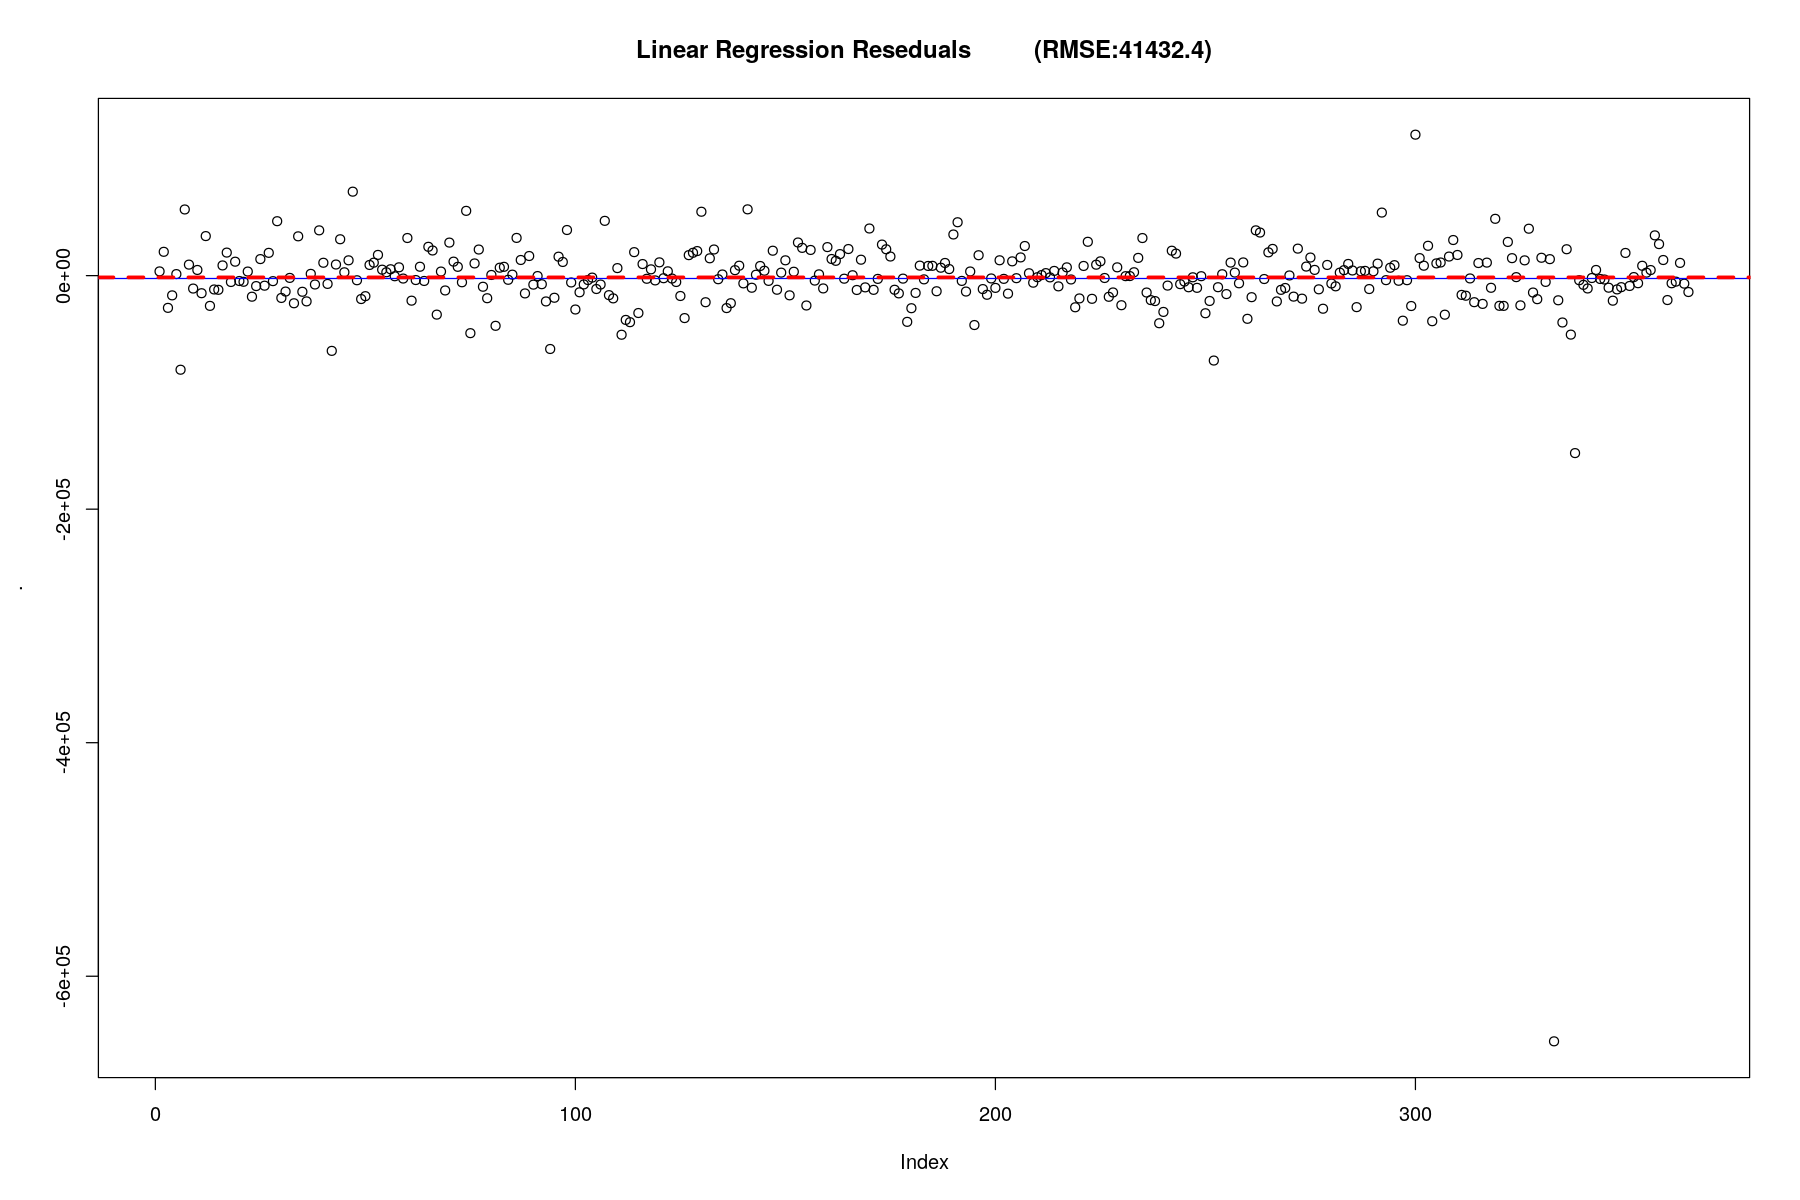

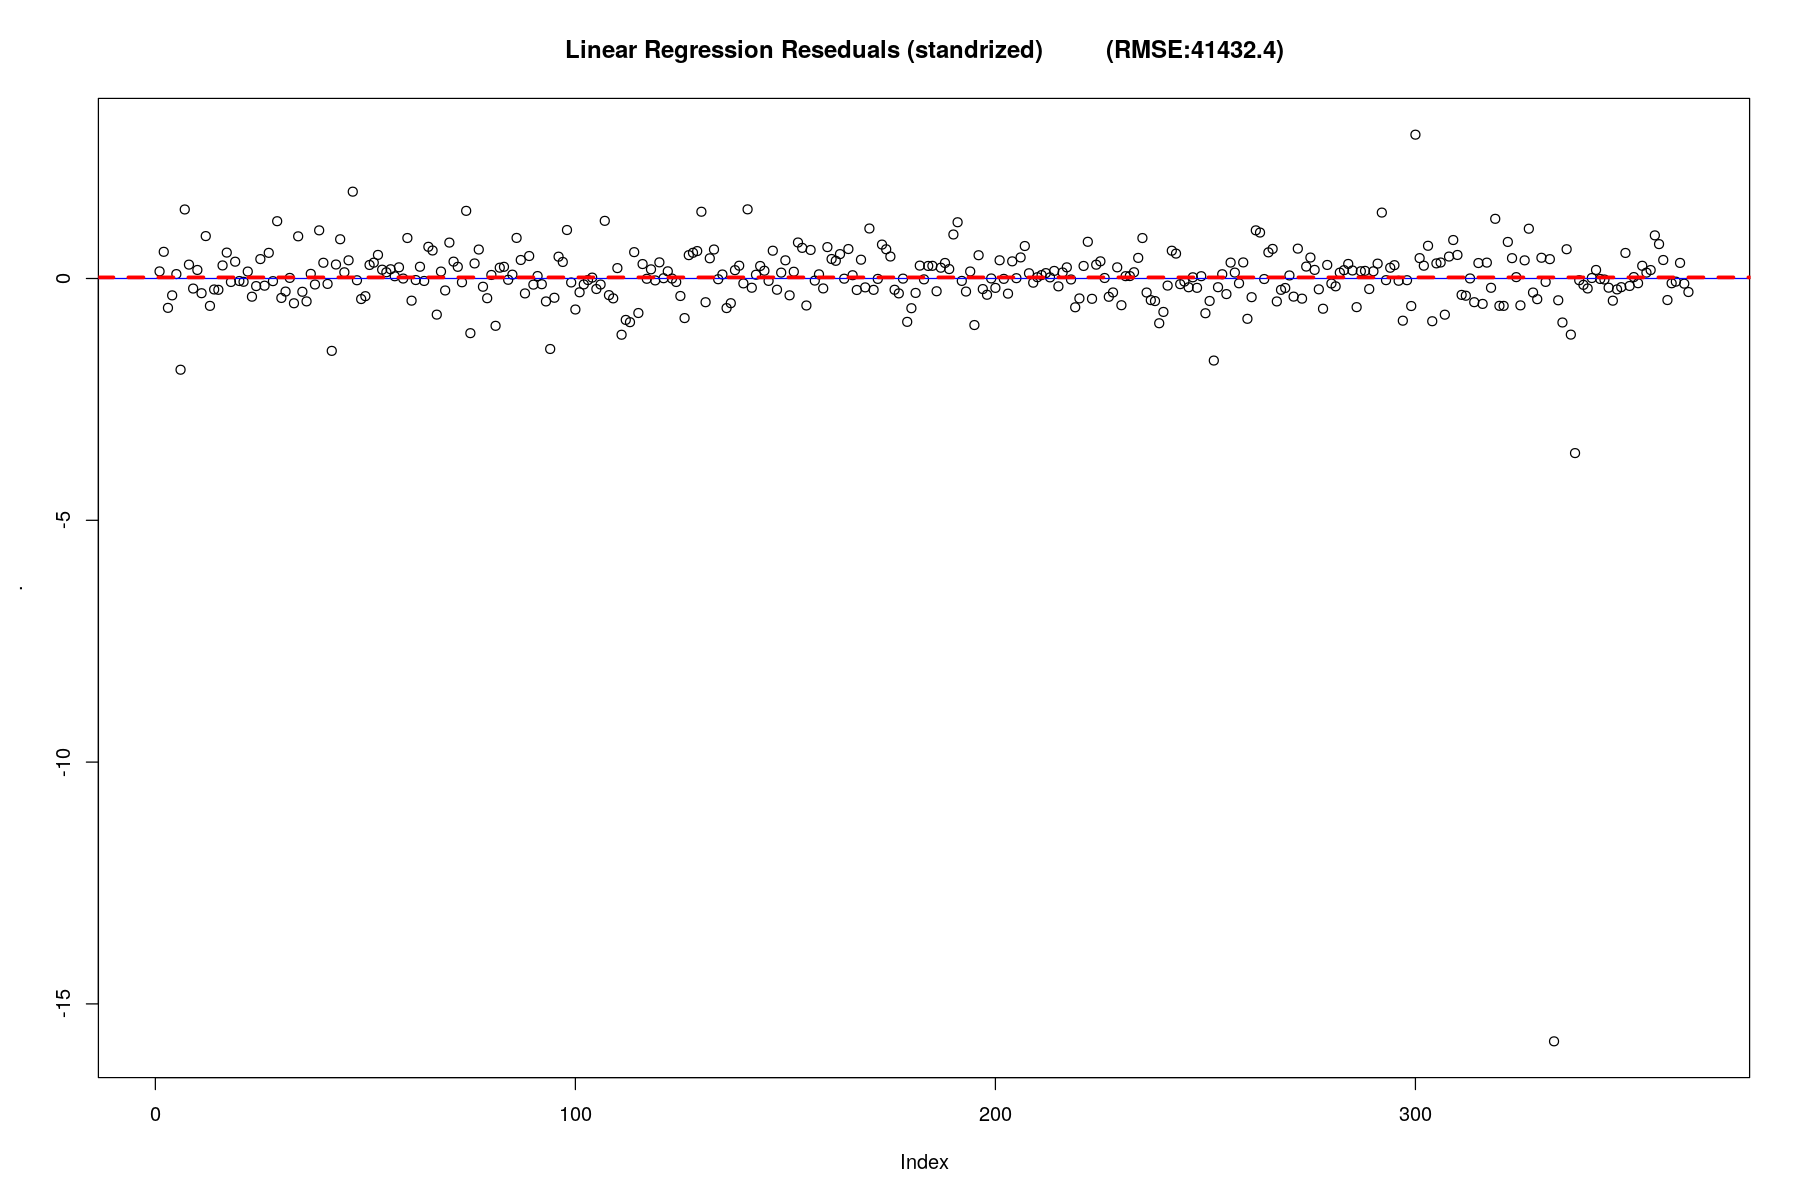



[1] "<<<<<<<<<<<<< Random Forest >>>>>>>>>>>>>"




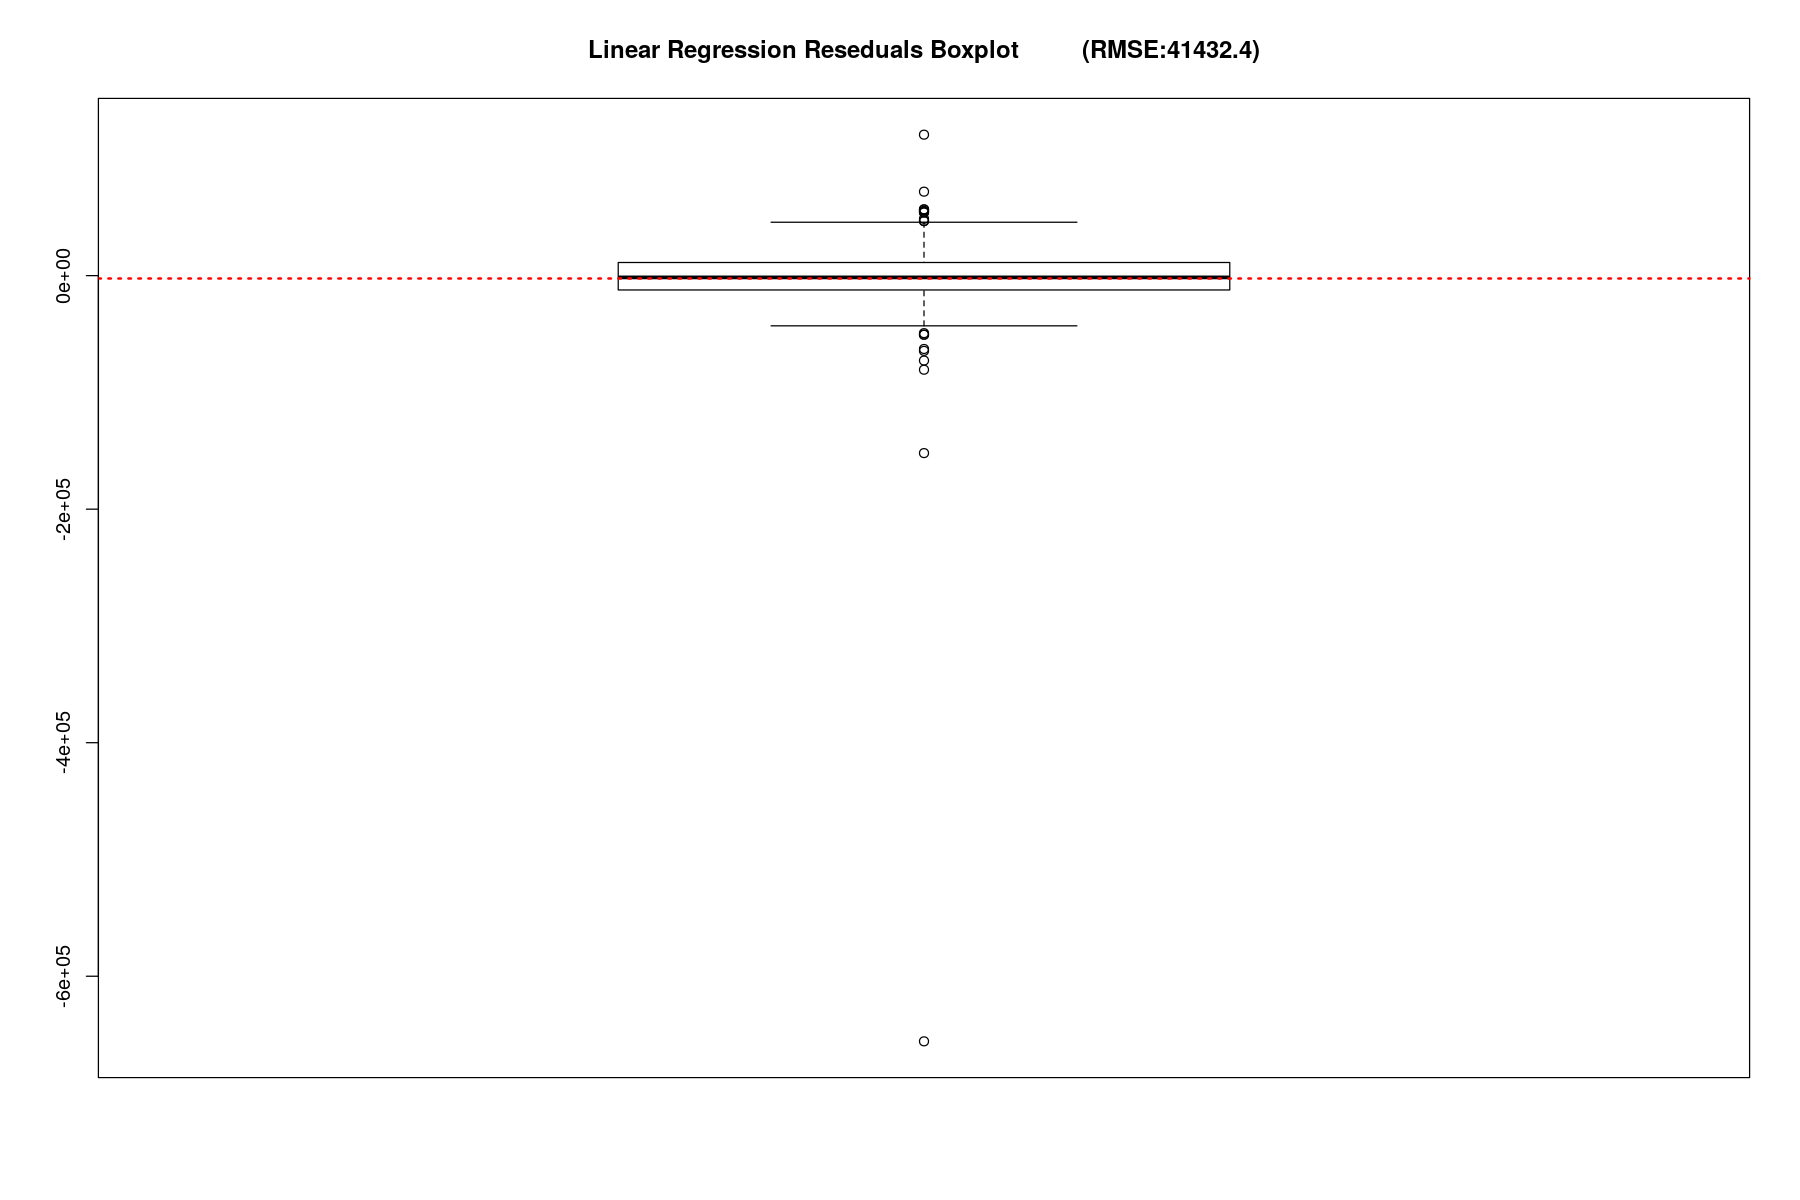

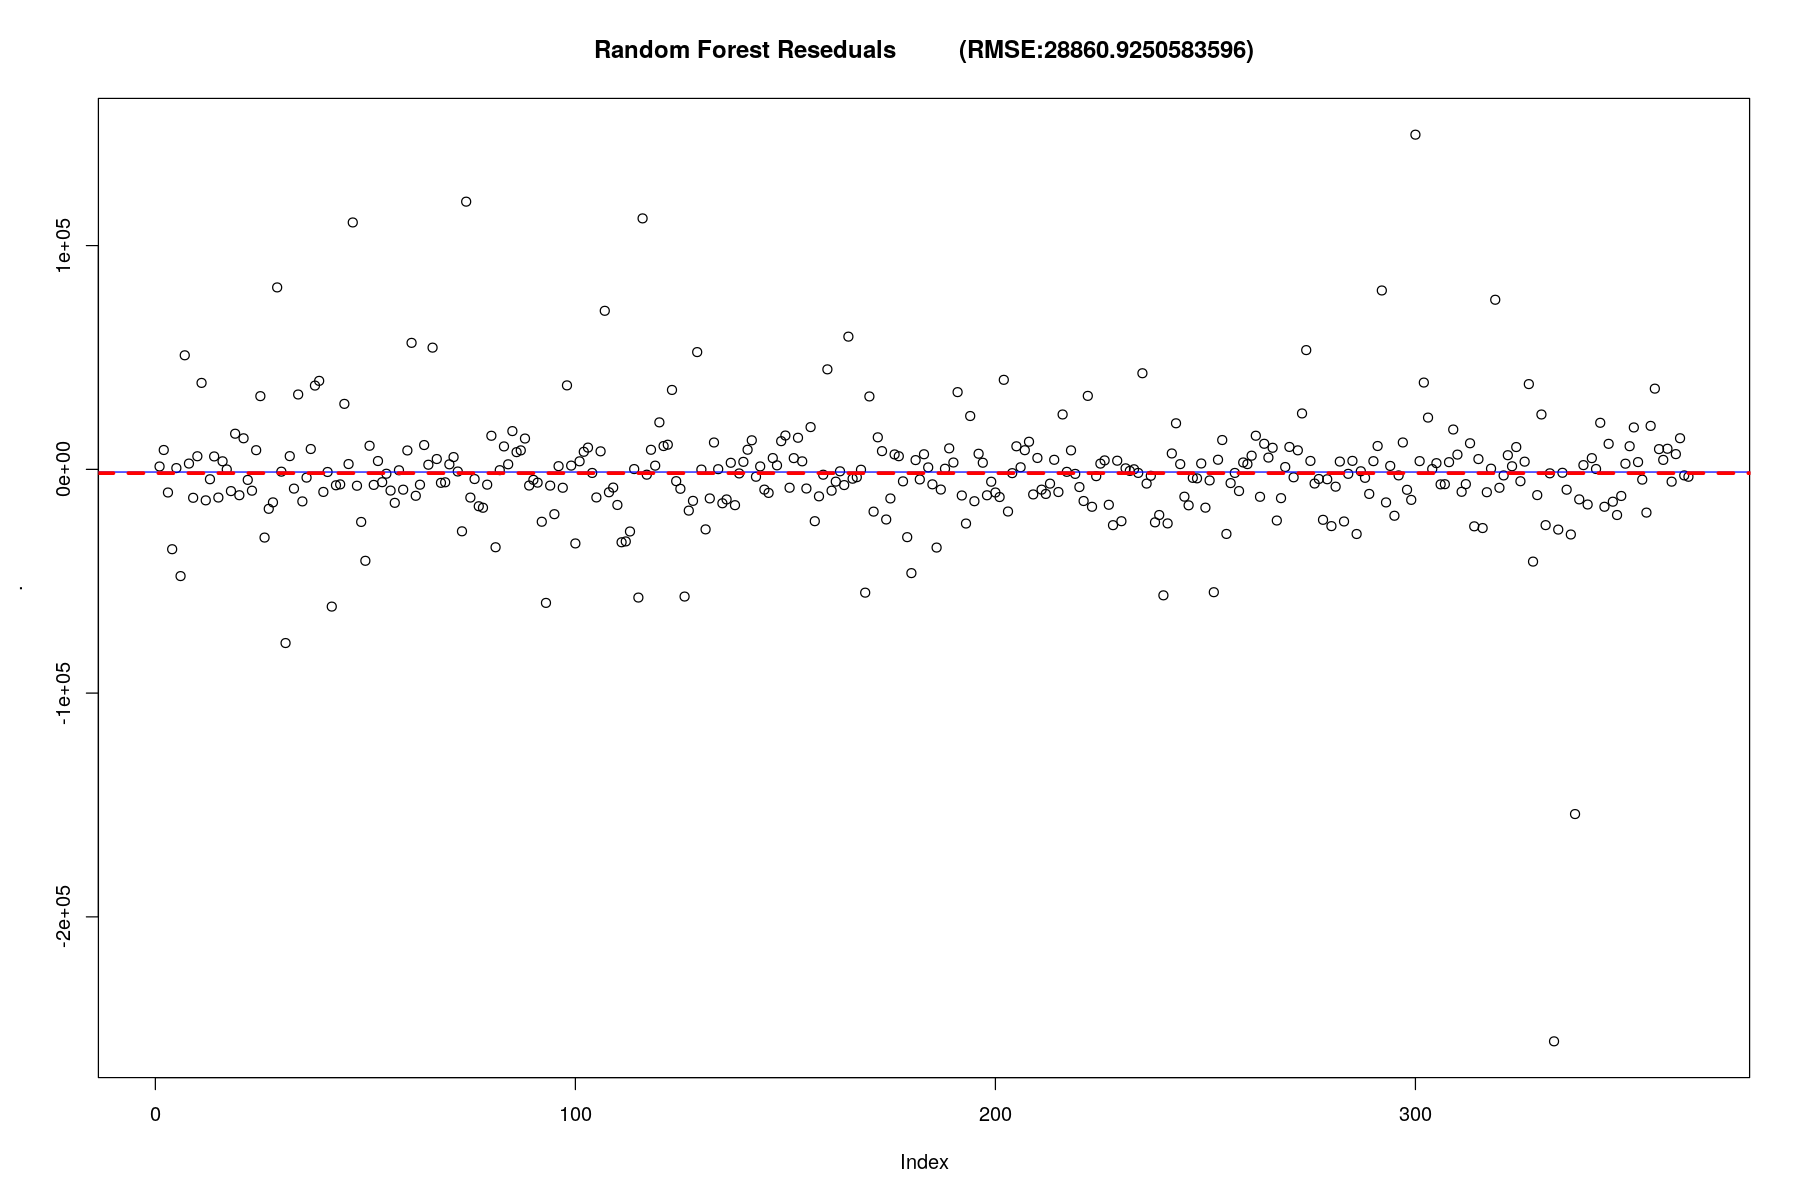

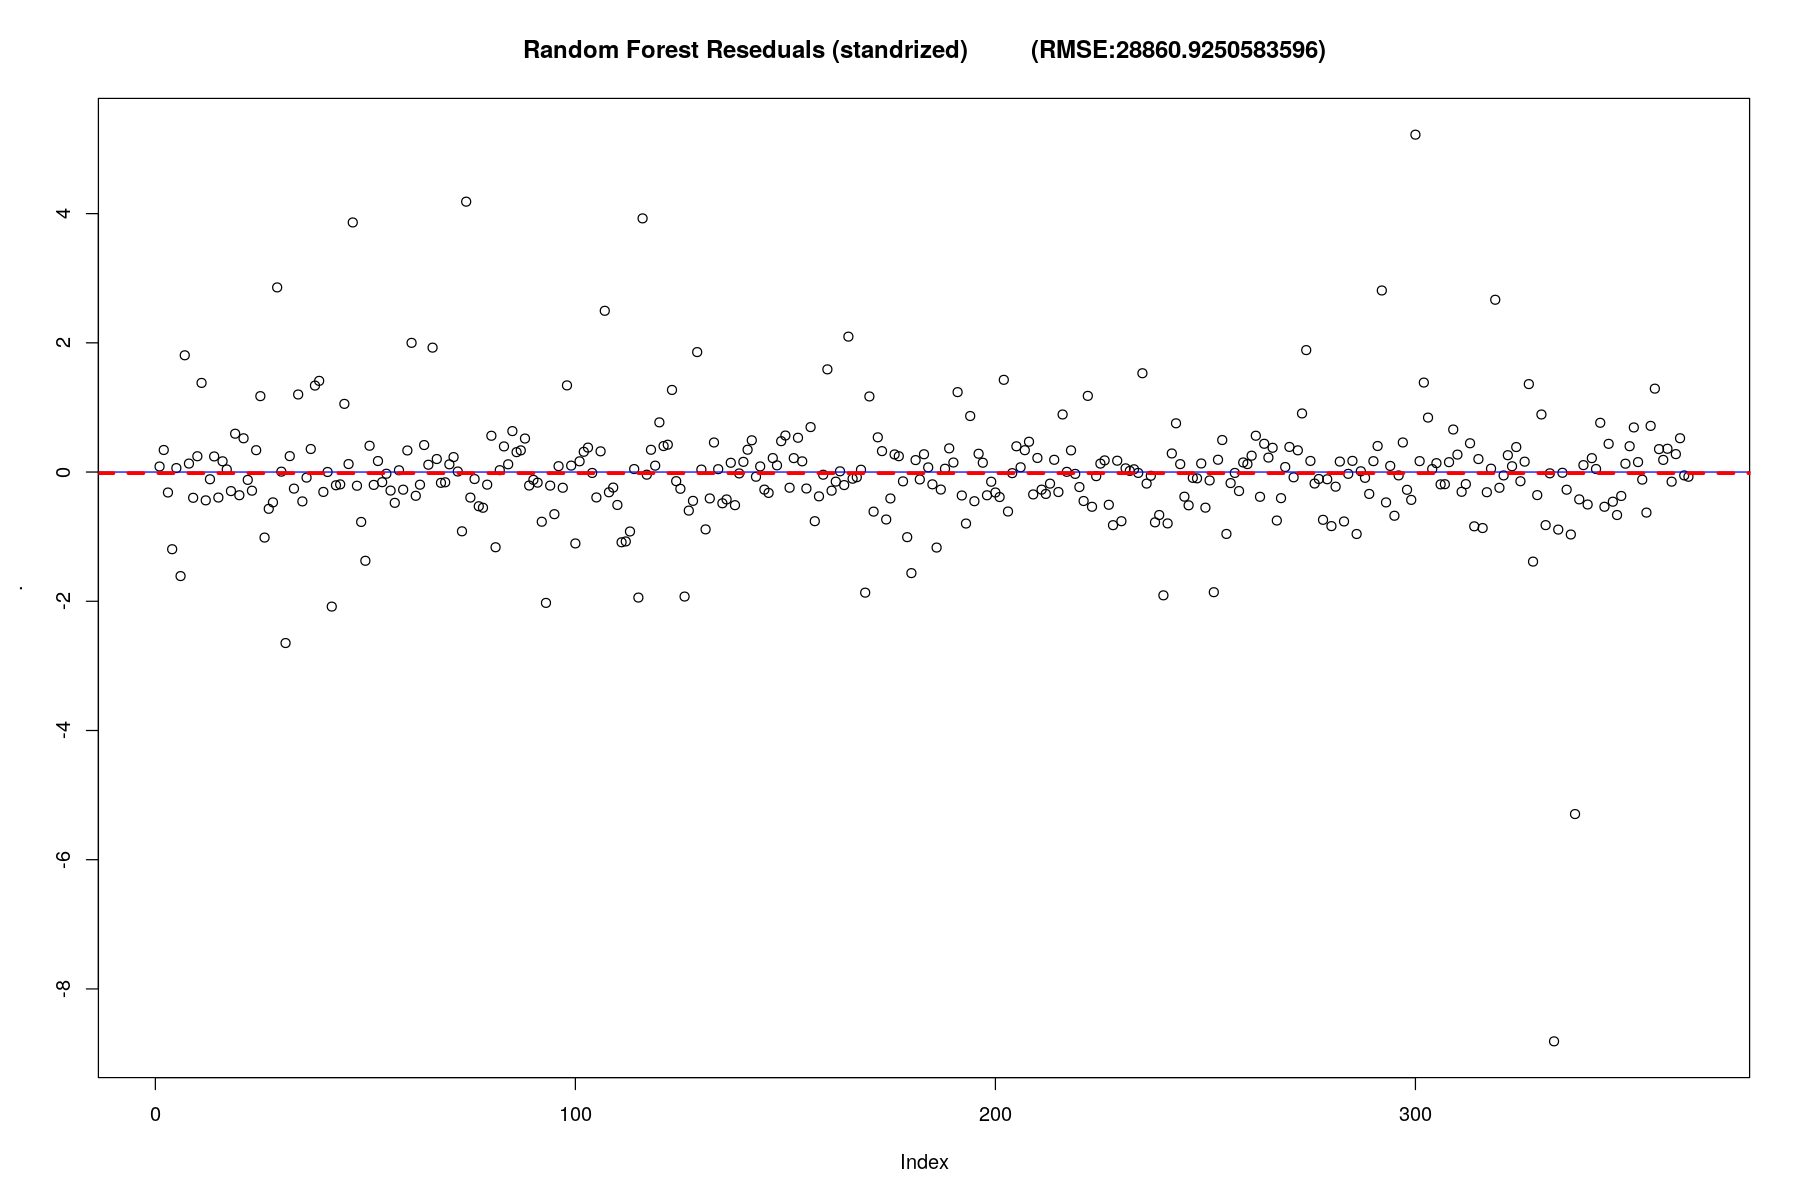



[1] "<<<<<<<<<<<<< KNN >>>>>>>>>>>>>"
The best K is  5 




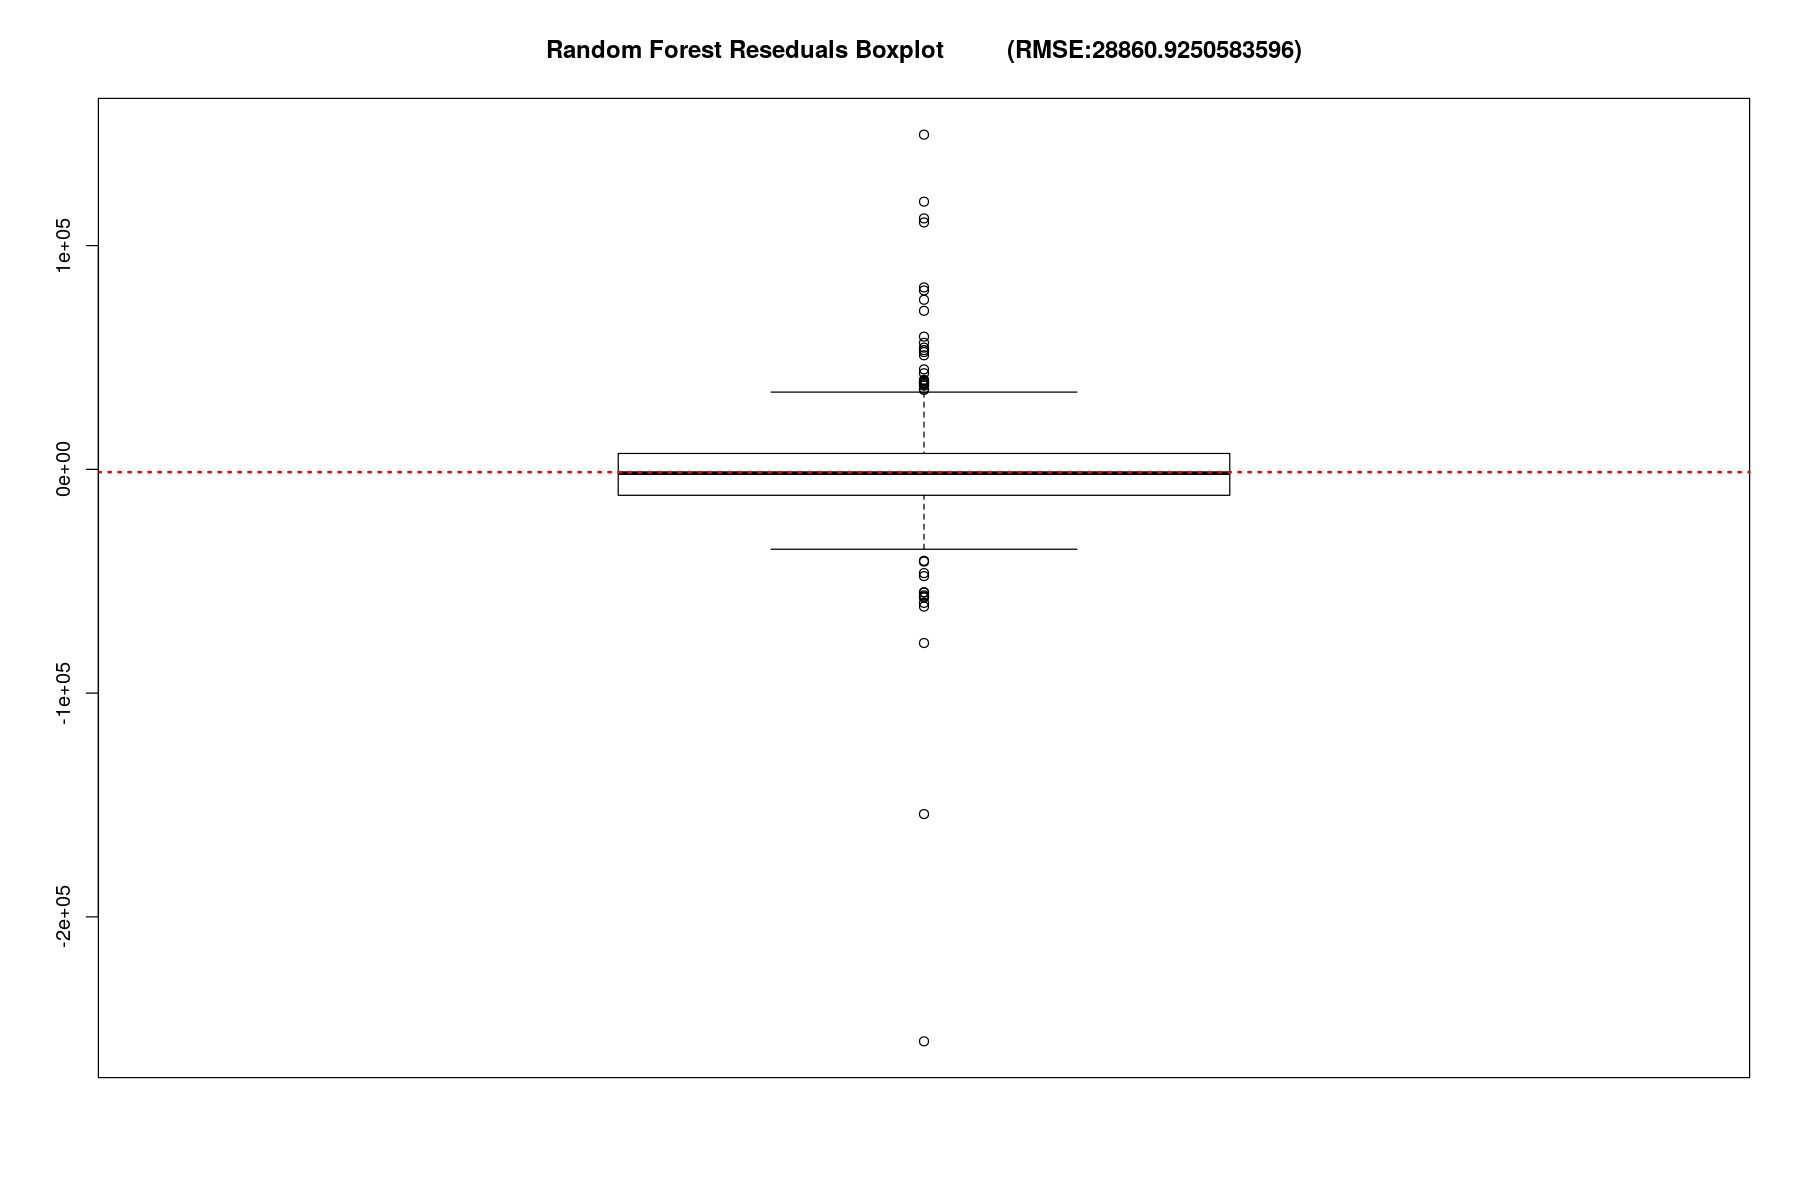

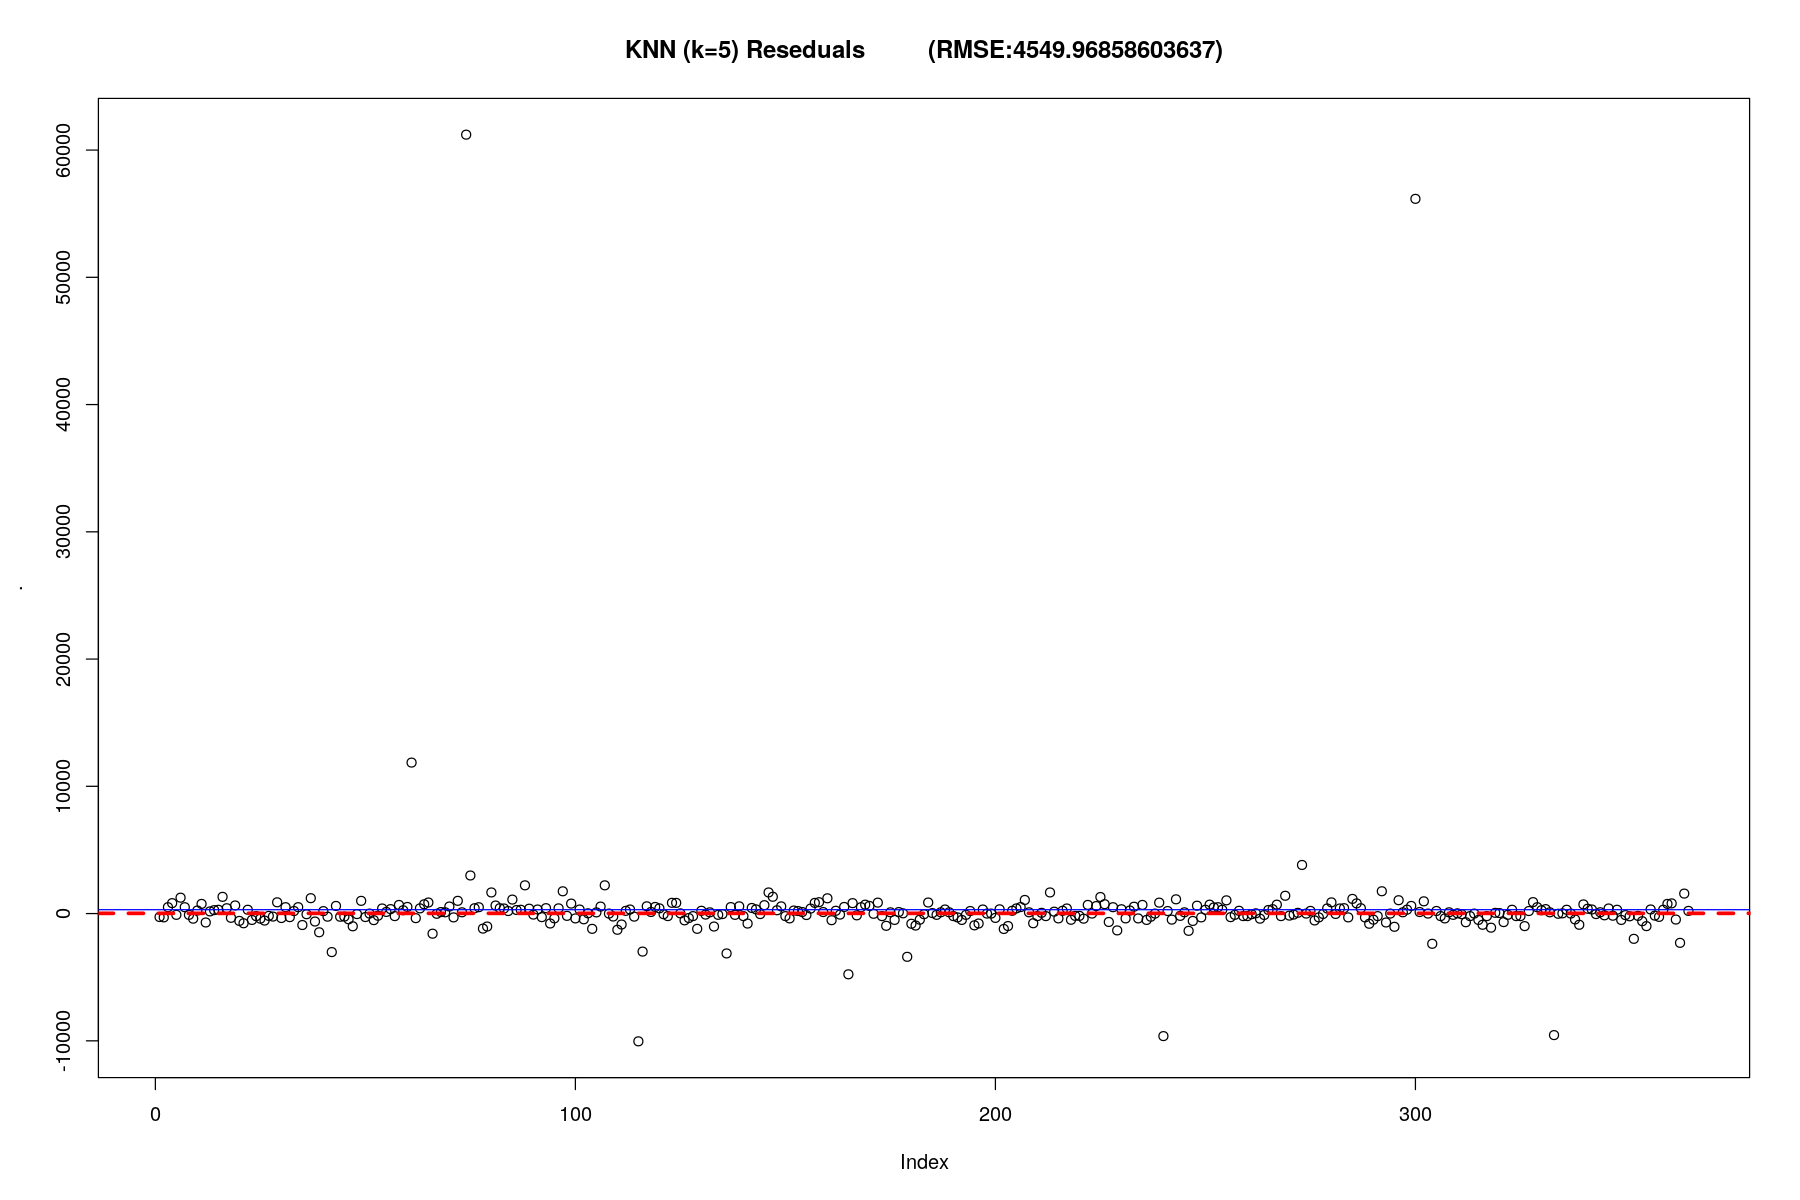

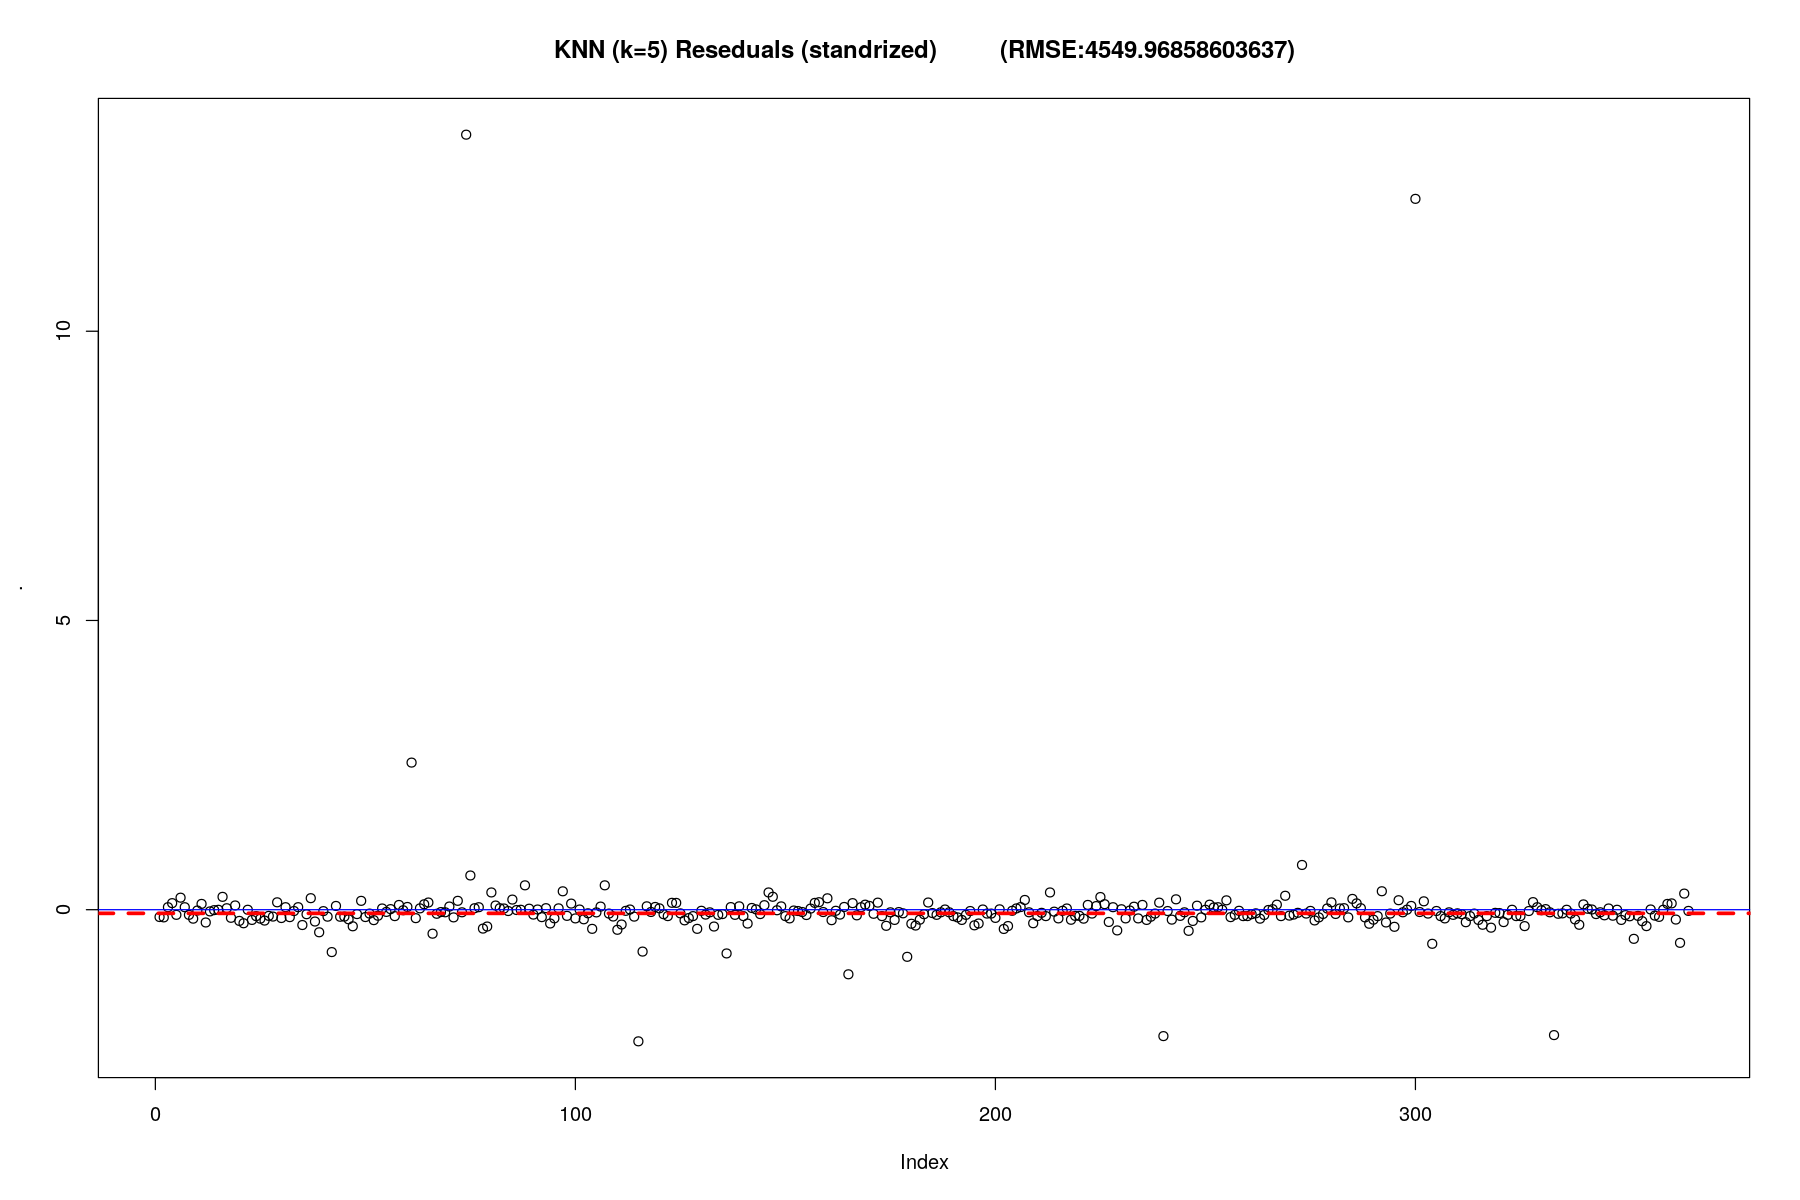



[1] "<<<<<<<<<<<<< SVM >>>>>>>>>>>>>"




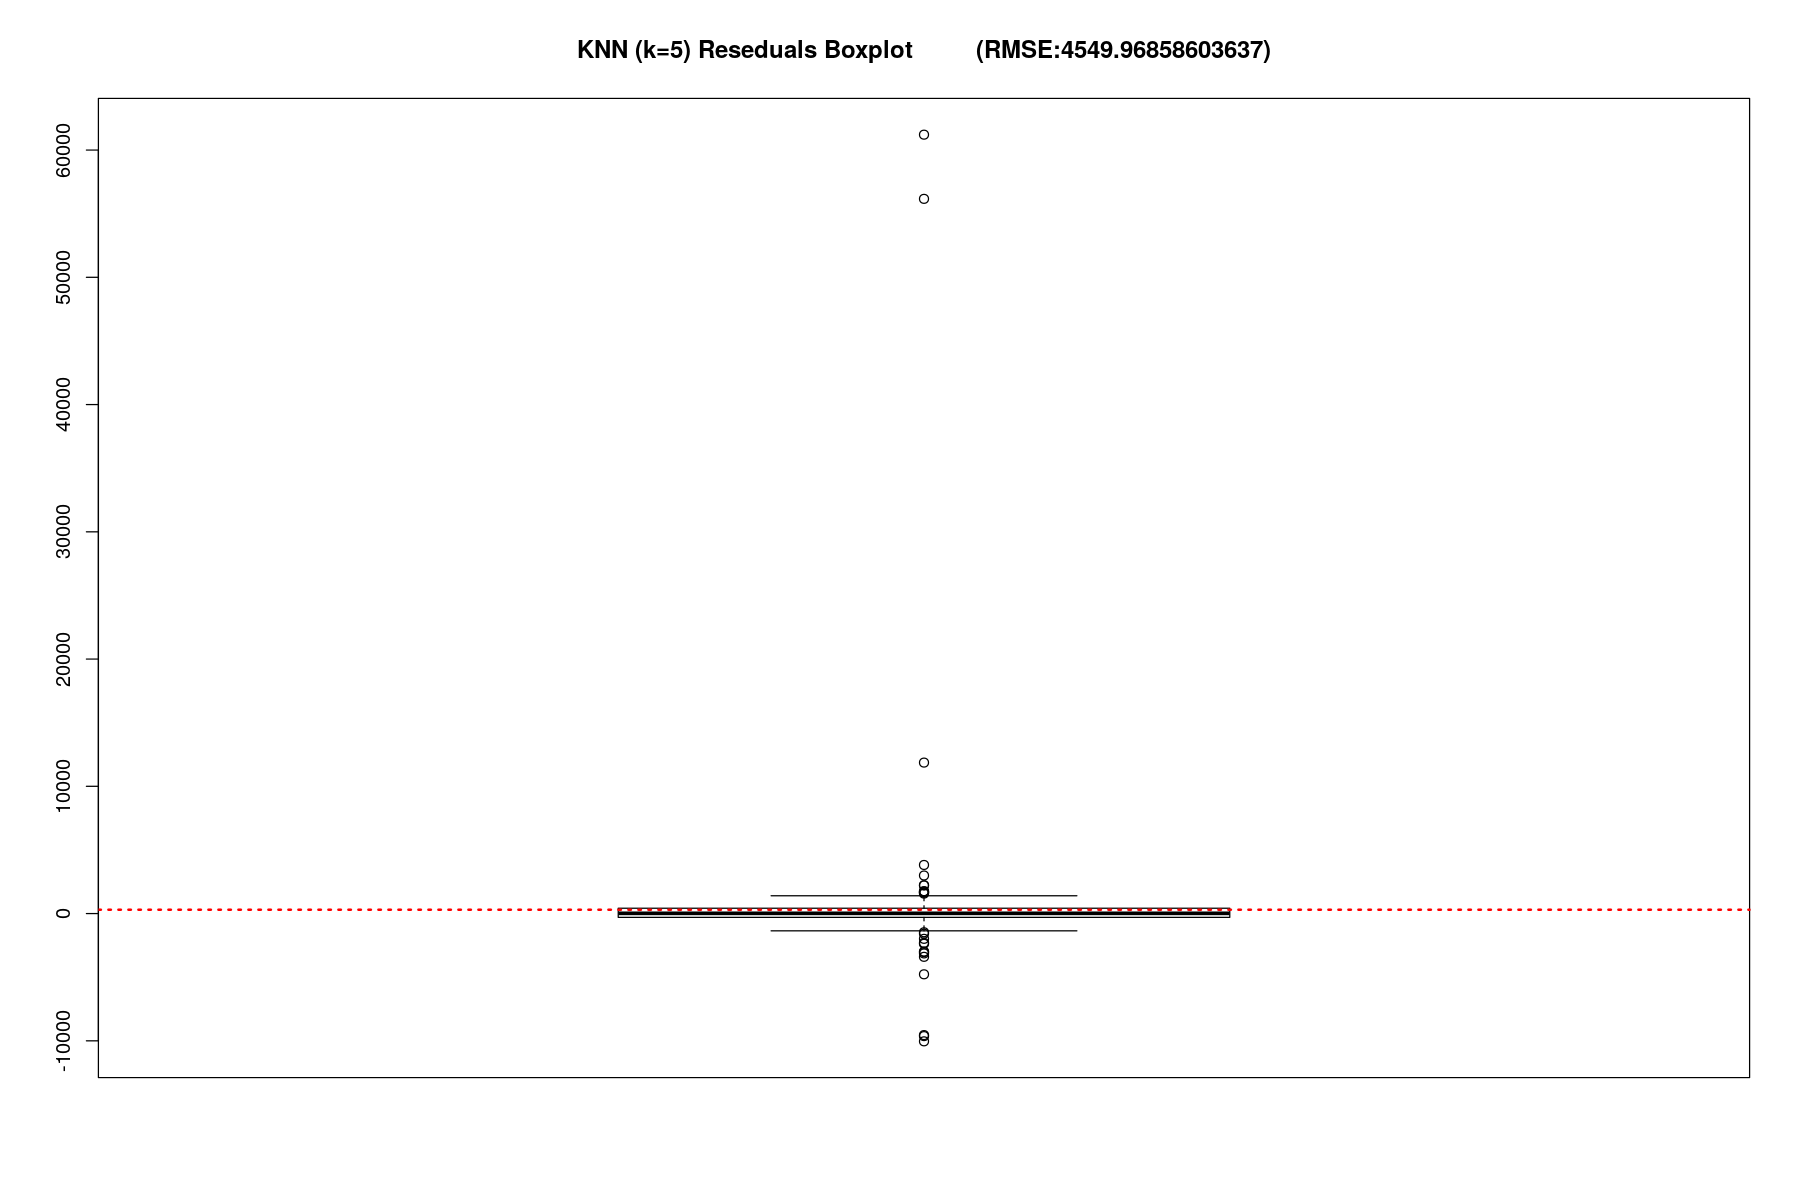

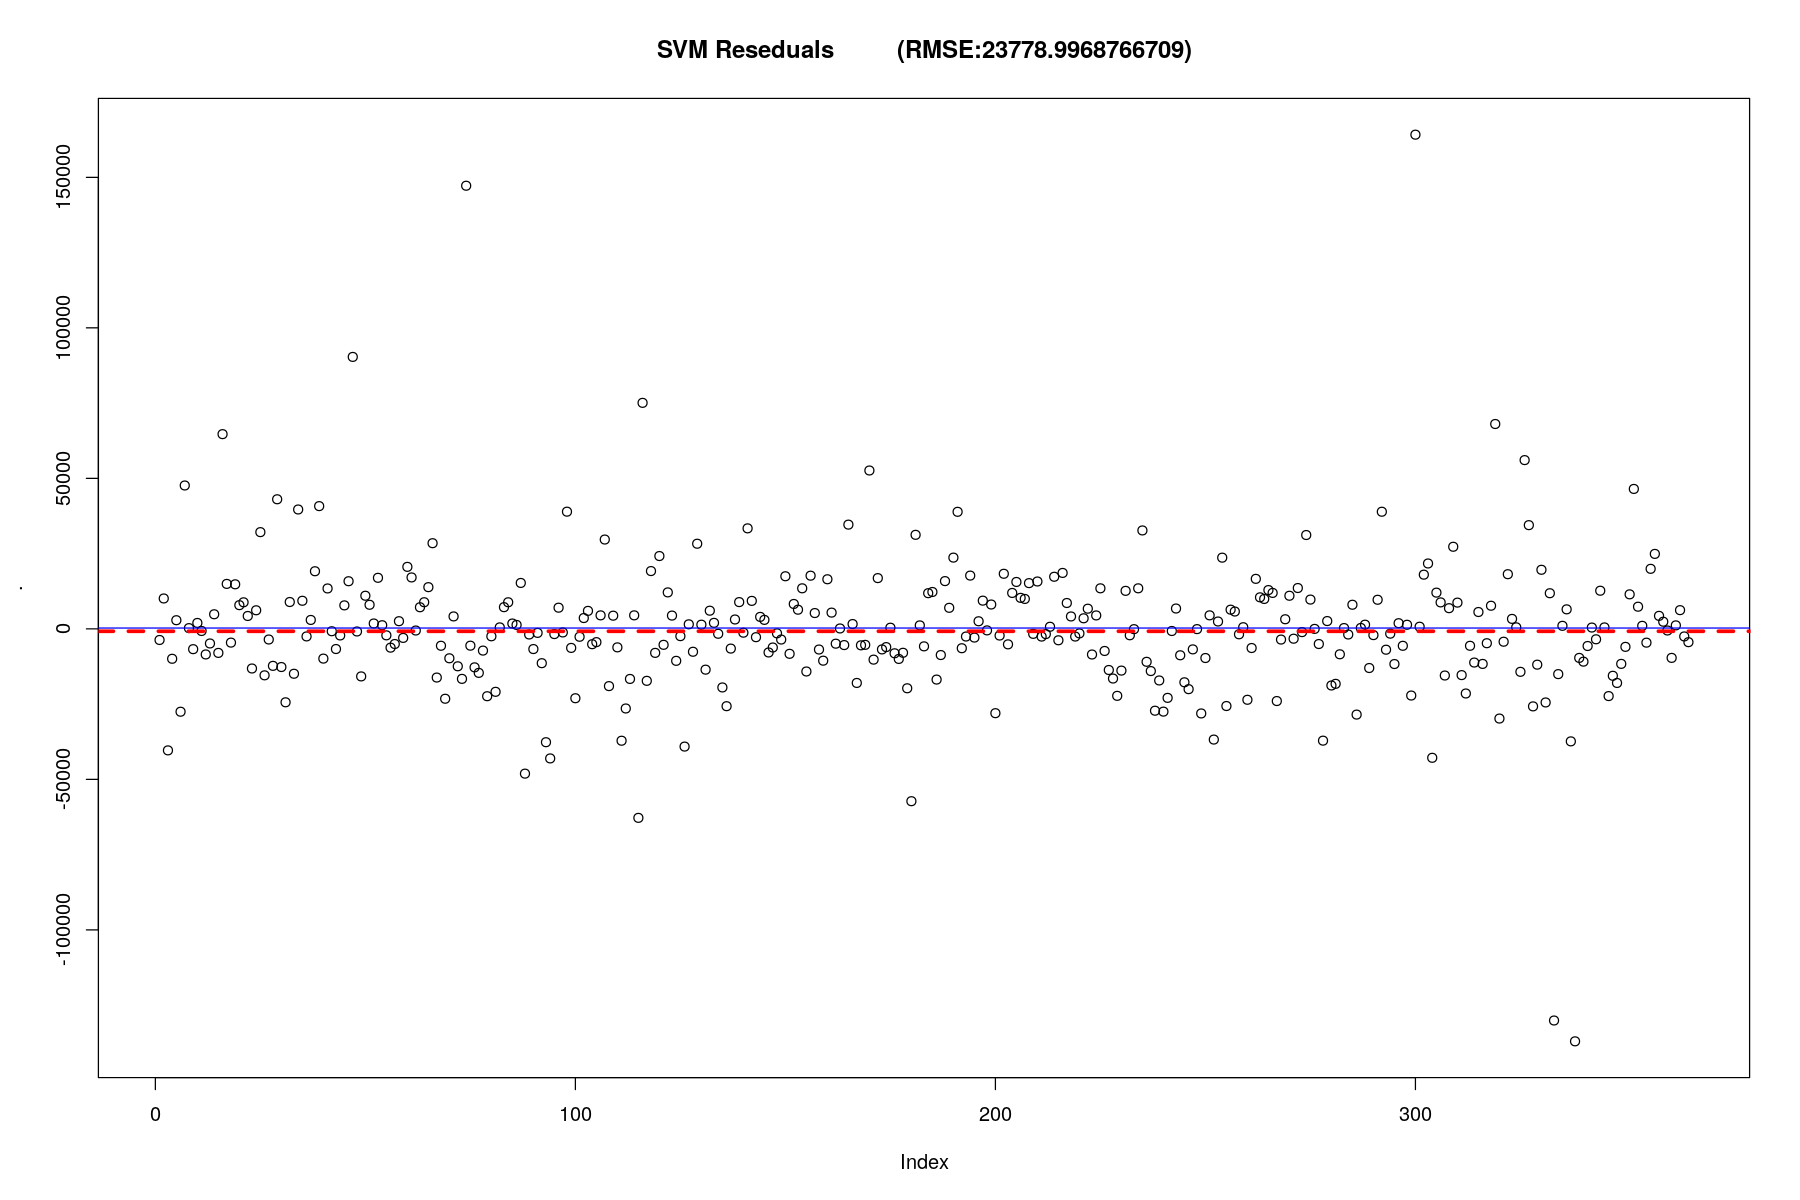

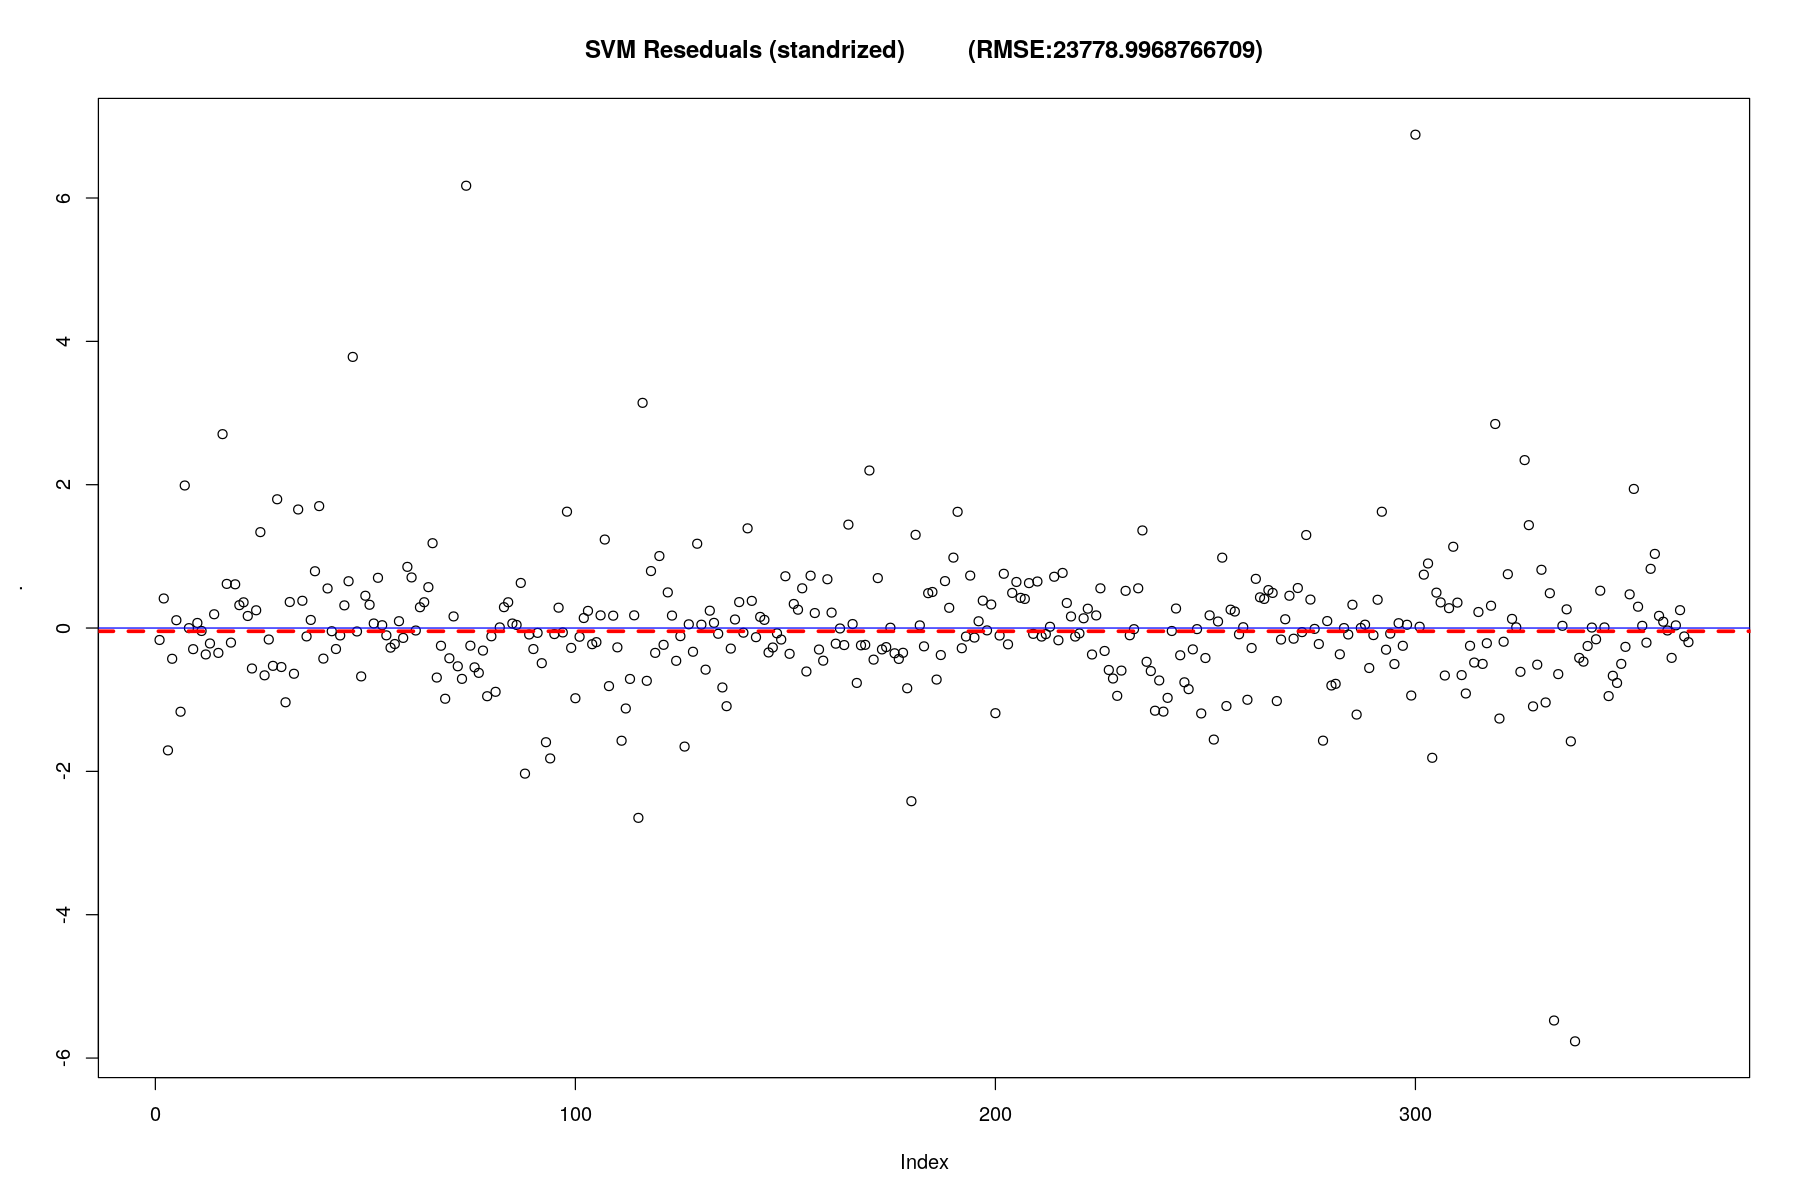



              Model  RMSE RMSE.base_line_RMSE
1               KNN  4550             0.06042
2               SVM 23779             0.31574
3     Random.Forest 28861             0.38322
4 Linear.regression 41432             0.55015



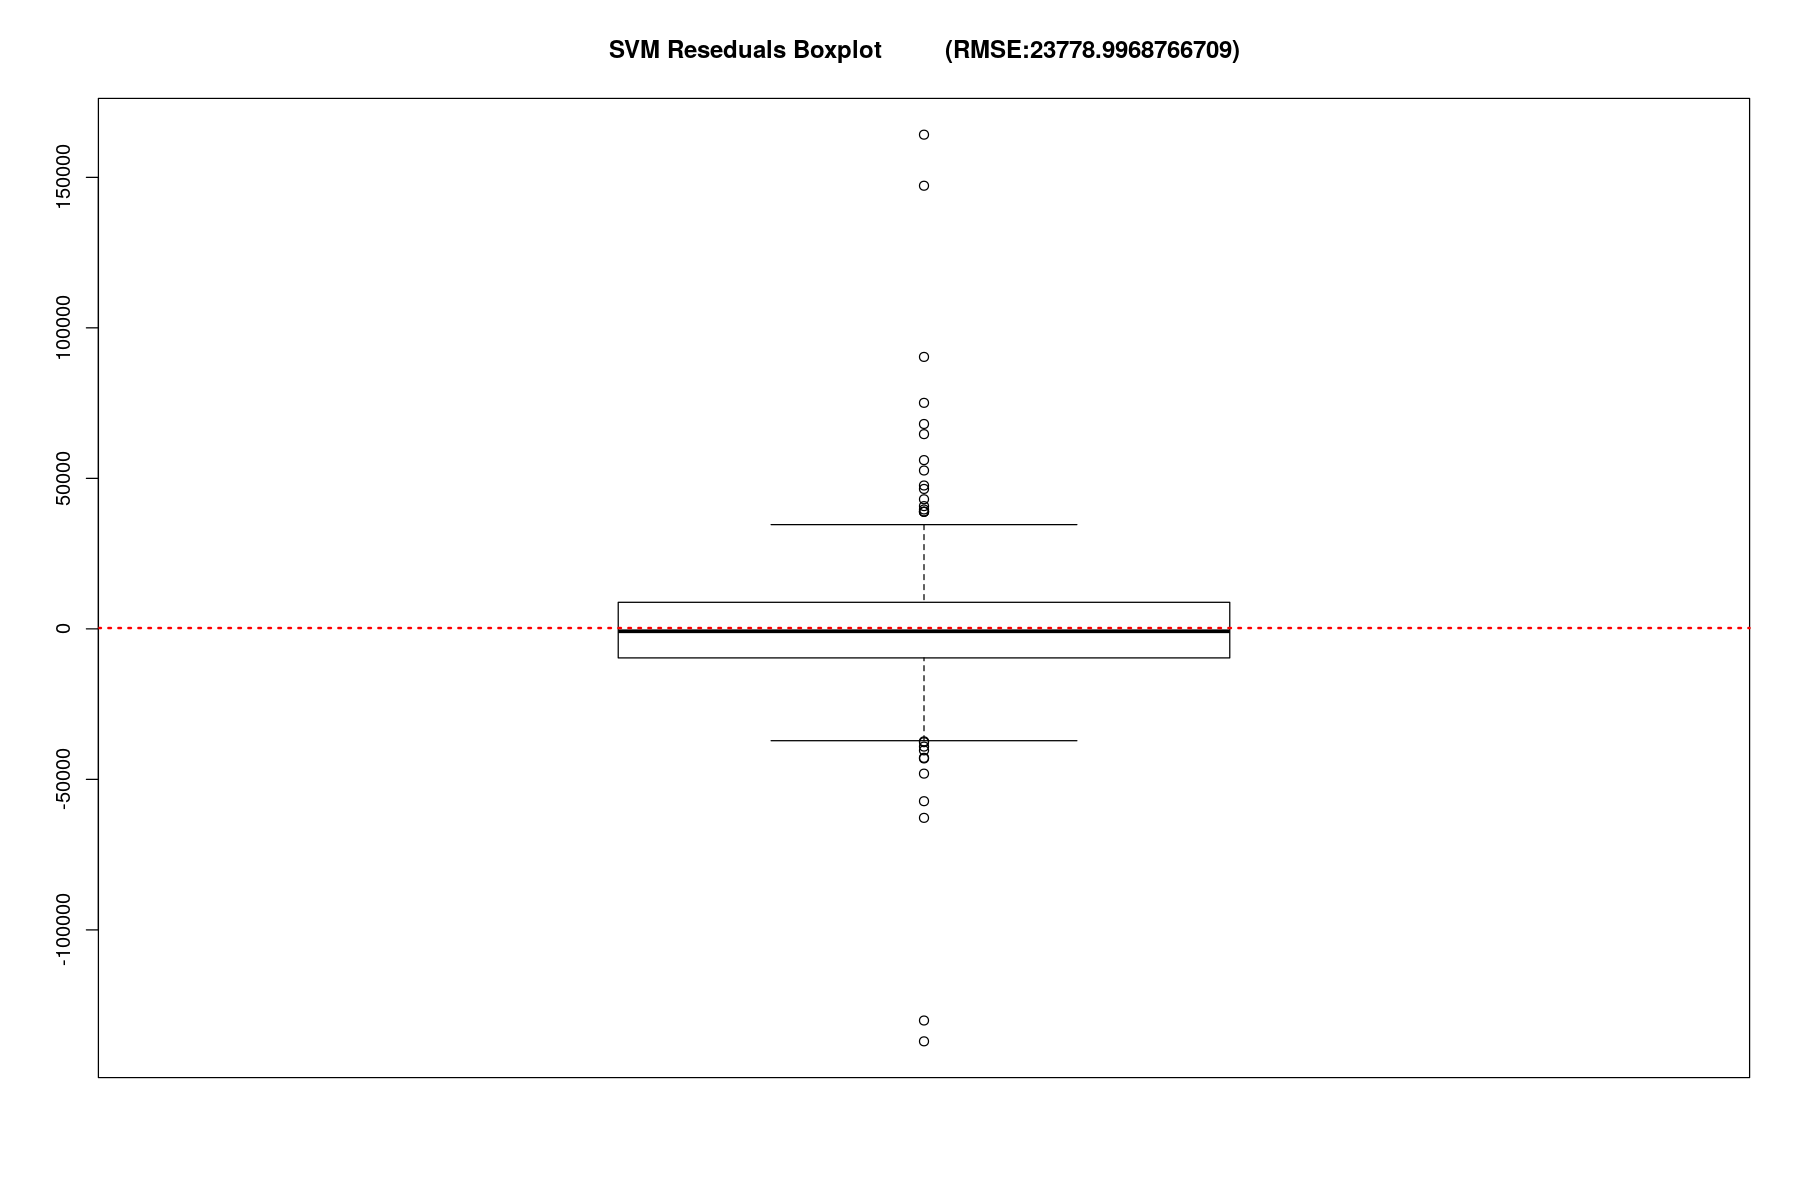

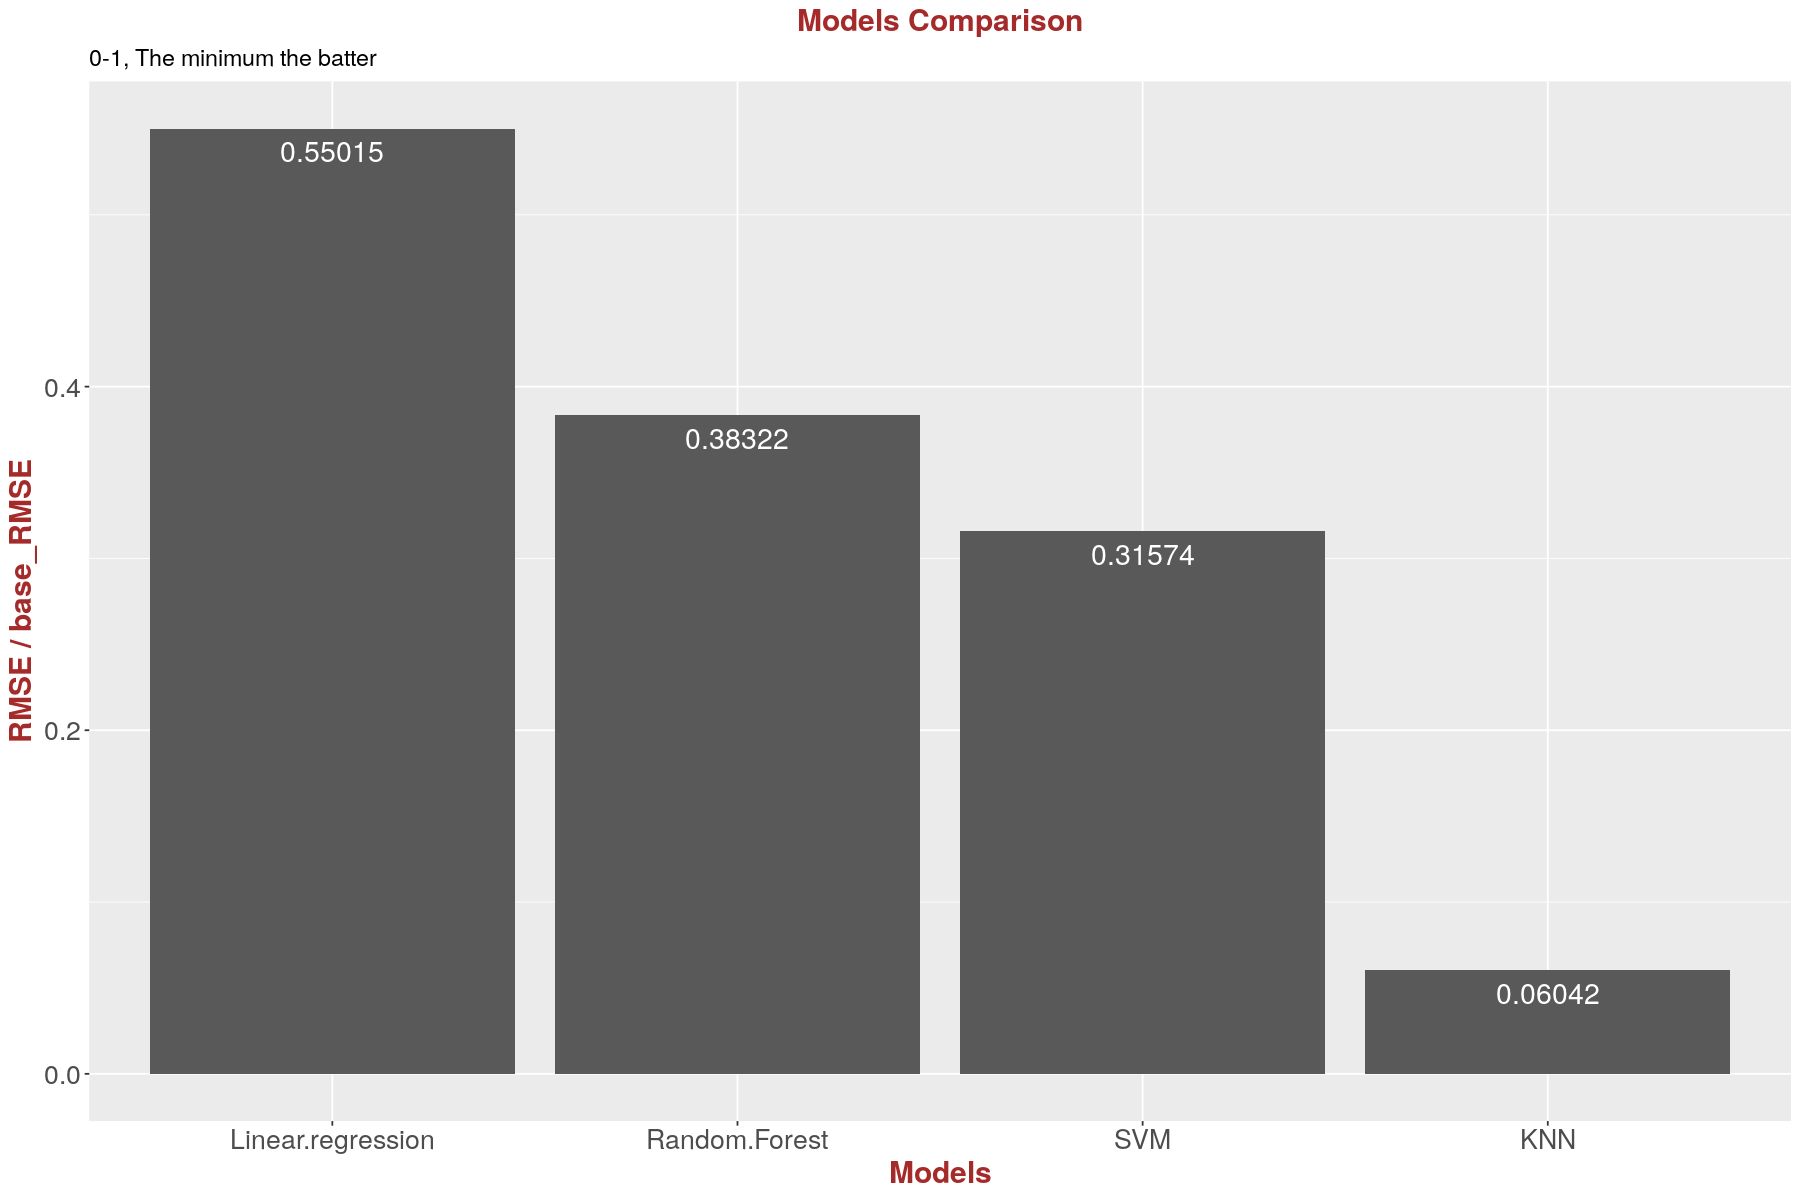

In [1]:
rm(list=ls())
library(ggplot2)
plot_func <- function(title_, errors_, RMSE_){
    title_ <- paste0(title_, " Reseduals")
    title_end <- paste0("         (RMSE:", RMSE_, ")")
    if (plot_ == TRUE){
        cat ("\n\n")
        errors_ %>% plot(main=paste0(title_, title_end))
        abline(h=c(mean(errors_),median(errors_)), col=c("blue", "red"), lty=c(1,2), lwd=c(1, 3))

        cat ("\n\n")
        errors__normalized <- (errors_ - mean(errors_)) / sd(errors_)
        errors__normalized %>% plot(main=paste0(title_, " (standrized)", title_end))
        abline(h=c(mean(errors__normalized),median(errors__normalized)), col=c("blue", "red"), lty=c(1,2), lwd=c(1, 3))

        cat ("\n\n")
        errors_ %>% boxplot(main=paste0(title_, " Boxplot", title_end))
        abline(h=mean(errors_), col="red", lty=3, lwd=2)
        Sys.sleep(1)
        cat("\n\n")
    }
}

library(e1071)
library(FNN)
library(ranger)
suppressWarnings(library(dplyr))
library(readr)

options(repr.plot.width = 15, repr.plot.height = 10)

# plot_ = FALSE
plot_ = TRUE

df <- read.csv("df.csv")
target_variable_name <- read_file("target_variable.txt")

smp_size <- floor(0.75 * nrow(df))
train_ind <- sample(seq_len(nrow(df)), size = smp_size)
train <- df[train_ind, ]
test <- df[-train_ind, ]
test_y <- test[[target_variable_name]]

base_test_RMSE <- mean((test_y - mean(test_y))**2) %>% sqrt %>% round

if  ( is.numeric( df[[target_variable_name]] ) ){
    cat("\n----------------- This is a Regression Problem -----------------\n\n")
    print("<<<<<<<<<<<<< Linear Regression >>>>>>>>>>>>>")
    # ----------------------------- Linear regression -----------------------------
    # lm.full <- lm(as.formula(paste(target_variable_name, " ~ .")), data = train)
    # lm.null <- lm(as.formula(paste(target_variable_name, " ~ 1")), data = train)
    #
    # model_LR.aic.both <- step(
    #   lm.full, direction = "both", scope = as.formula(paste(target_variable_name, "~ ", paste(names(train), collapse = " + ")))
    # )
    # cat("\nLinear regression model saved as <model_LR.aic.both.rda>\n")
    # save(model_LR.aic.both, file="model_LR.aic.both.rda")
    load("model_LR.aic.both.rda")

    model_LR_final <- lm(
                        as.formula(
                            paste(target_variable_name, " ~ ", paste(names(model_LR.aic.both$model)[-c(1)], collapse = " + "))
                        ), data=train)
    summary_LR <- (model_LR_final %>% summary)
    f_value_LR <- summary_LR$fstatistic[['value']]
    adj.r.squared_LR <- summary_LR$adj.r.squared
    predictions_LR <- model_LR_final %>% predict(test)
    errors_LR <- test_y - predictions_LR
    RMSE_LR <- errors_LR ^ 2 %>% mean %>% sqrt %>% round(2)

    # Plots
    plot_func(title_ = "Linear Regression", errors_ = errors_LR, RMSE_=RMSE_LR)

    print("<<<<<<<<<<<<< Random Forest >>>>>>>>>>>>>")
    model_RF <- ranger(
            formula   = as.formula( paste(target_variable_name, " ~ .") ),
            data      = train,
            num.trees = 200,
            sample.fraction = 0.7,
            min.node.size = 4,
            classification = F,
            mtry = floor(ncol(train) / 3))
    model_RF <- predict(model_RF, test)
    predictions_RF <- model_RF$predictions
    errors_RF <- test_y - predictions_RF
    RMSE_RF <- errors_RF ^ 2 %>% mean %>% sqrt

    # Plots
    plot_func(title_ = "Random Forest", errors_ = errors_RF, RMSE_=RMSE_RF)


    print("<<<<<<<<<<<<< KNN >>>>>>>>>>>>>")
    # get only numeric columns
    train_KNN <- Filter(is.numeric, train)
    test_KNN  <- Filter(is.numeric, test)
    x = 3:20
    res <- c()
    for (i in x){
        predictions_KNN = knn.reg(train = train_KNN, test = test_KNN, y = train_KNN[[target_variable_name]], k = i)$pred
        errors_KNN <- test_KNN[[target_variable_name]] - predictions_KNN
        res <- append(res, round(mean(errors_KNN <= 0.15), 2))
    }

    cat("The best K is ", x[which.max(res)], "\n")
    predictions_KNN = knn.reg(train = train_KNN, test = test_KNN, y = train_KNN[[target_variable_name]], k = x[which.max(res)])$pred
    errors_KNN = test_KNN[[target_variable_name]] - predictions_KNN
    RMSE_KNN <- errors_KNN ^ 2 %>% mean %>% sqrt
    rm(train_KNN, test_KNN)

    # Plots
    plot_func(title_ = paste0("KNN (k=", x[which.max(res)], ")"), errors_ = errors_KNN, RMSE_=RMSE_KNN)

    print("<<<<<<<<<<<<< SVM >>>>>>>>>>>>>")
    model_svm <- svm(as.formula( paste(target_variable_name, " ~ .") ),train)
    predictions_SVM  <- model_svm %>% predict(test)
    errors_SVM <- test_y - predictions_SVM
    RMSE_SVM <- errors_SVM ^ 2 %>% mean %>% sqrt

    # Plots
    plot_func(title_ = "SVM", errors_ = errors_SVM, RMSE_=RMSE_SVM)
}

f <- list("Linear regression"=c(RMSE_LR, RMSE_LR / base_test_RMSE),
          "Random Forest"=c(RMSE_RF, RMSE_RF / base_test_RMSE),
          "KNN"=c(RMSE_KNN, RMSE_KNN / base_test_RMSE),
          "SVM"=c(RMSE_SVM, RMSE_SVM / base_test_RMSE))
# f <- f[order(-unlist(f))]
# k <- names(f)
# v <- as.numeric(f)
# cat("=== Models RMSE (sorted) ===\n\n")
# for (i in seq(1:length(k))){
#     print(paste(k[[i]],round(v[[i]])))
# }
models_summary <- data.frame(f, row.names=c("RMSE", "RMSE/base_line_RMSE")) %>% t %>% data.frame()
models_summary$Model <- models_summary %>% row.names
row.names(models_summary) <- 1:nrow(models_summary)
models_summary$RMSE <- round(models_summary$RMSE)
models_summary <- models_summary %>% arrange(RMSE)
models_summary$RMSE.base_line_RMSE <- models_summary$RMSE.base_line_RMSE %>% round(5)

print(models_summary[,c(3,1,2)])
cat("\n")

models_summary %>% ggplot(aes(x=reorder(Model, -RMSE.base_line_RMSE), y=RMSE.base_line_RMSE	)) +
                geom_bar(stat="identity") +
                geom_text(aes(label=RMSE.base_line_RMSE), vjust=1.6, color="white", size=6)+
                labs(
                    title="Models Comparison",
                    x = "Models",
                    y = "RMSE / base_RMSE",
                    subtitle = "0-1, The minimum the batter") +
                theme(
                    plot.title   = element_text(size=18, color='brown', face="bold", hjust = 0.5),
                    axis.title.x = element_text(size=18, color='brown', face="bold"),
                    axis.title.y = element_text(size=18, color='brown', face="bold"),
                    axis.text=element_text(size=16),
                    plot.subtitle = element_text(size=14, color='black')
                    )
